In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

In [2]:
# Get current working directory
os.getcwd()
# Change current working directory to one folder up
os.chdir('../../')
# Check current working directory is as expected
os.getcwd()

'/home/moc0/ai-vegetation-fuel'

In [3]:
# H2O AutoML framework for benchmarking
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size = 32)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_291"; Java(TM) SE Runtime Environment (build 1.8.0_291-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from /home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpg6fdtq5o
  JVM stdout: /tmp/tmpg6fdtq5o/h2o_moc0_started_from_python.out
  JVM stderr: /tmp/tmpg6fdtq5o/h2o_moc0_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_moc0_w6hmfx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.44 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


# Load data

In [4]:
# Load raw train data
train = pd.read_csv(os.getcwd() + "/data/inputs/train_raw_interpTrue.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})

# Load raw test data
test = pd.read_csv(os.getcwd() + "/data/inputs/test_raw_interpTrue.csv",
                    dtype={'climatic_region':'category',
                           'biome':'category',
                           'GFEDregions':'category'})

In [5]:
train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'vod'}>,
        <AxesSubplot:title={'center':'lai'}>],
       [<AxesSubplot:title={'center':'spi03'}>,
        <AxesSubplot:title={'center':'spi06'}>,
        <AxesSubplot:title={'center':'spi12'}>,
        <AxesSubplot:title={'center':'d2m'}>,
        <AxesSubplot:title={'center':'erate'}>],
       [<AxesSubplot:title={'center':'fg10'}>,
        <AxesSubplot:title={'center':'si10'}>,
        <AxesSubplot:title={'center':'swvl1'}>,
        <AxesSubplot:title={'center':'t2m'}>,
        <AxesSubplot:title={'center':'tprate'}>],
       [<AxesSubplot:title={'center':'danger_risk'}>,
        <AxesSubplot:title={'center':'fwinx'}>,
        <AxesSubplot:title={'center':'ffmcode'}>,
        <AxesSubplot:title={'center':'dufmcode'}>,
        <AxesSubplot:title={'center':'drtcode'}>],
       [<AxesSubplot:titl

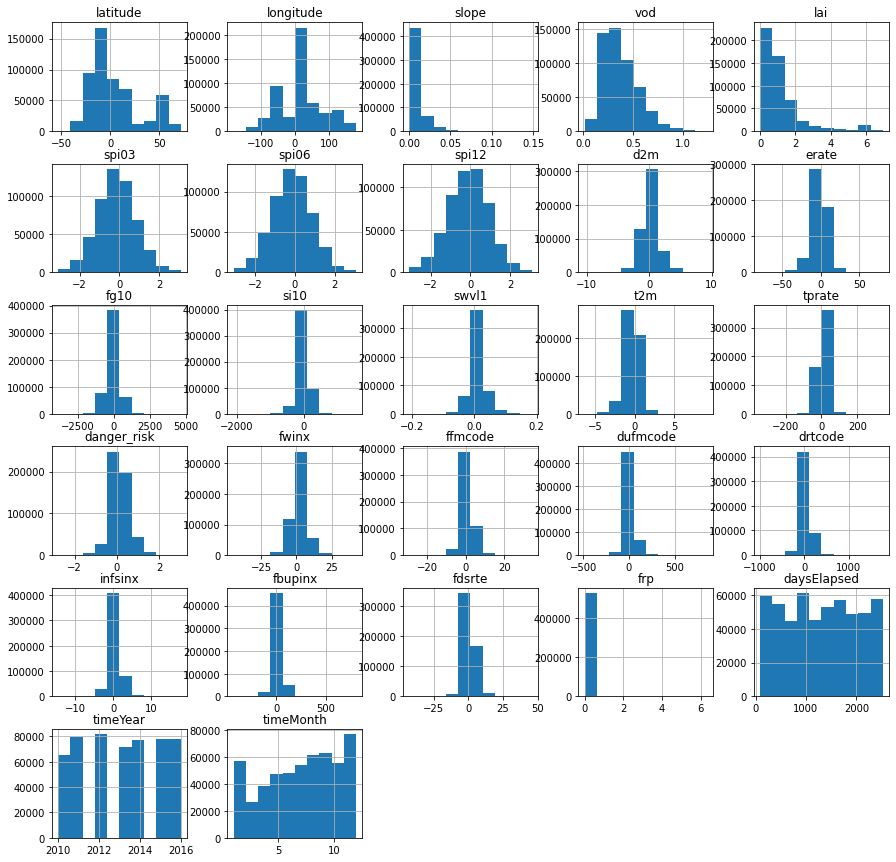

In [9]:
trainx = train.drop('fuel_load', axis = 1)
trainx.hist(figsize = (15,15))

## Model selection and further processing

Following the results of the benchmark tests, the final configuration selected is the one that uses log-transformed target and Y-J transformed continuous predictors. An extended training of this model is run below with a max runtime of 24 hours.

In [10]:
# Define outcome variable
y = 'fuel_load'

# Log-transform outcome variable
train[y] = np.log(train[y])
test[y] = np.log(test[y])

In [11]:
# categorical features
cat_features = ['climatic_region', 'biome', 'GFEDregions']
# numerical features
num_features = train.columns.to_list()
for i in [y] + cat_features:
    num_features.remove(i)

In [12]:
# PowerTransform with sklearn
from sklearn.preprocessing import PowerTransformer

# copy of datasets
train_yj = train.copy()
test_yj = test.copy()

# apply transformation on numerical features
for i in num_features:
    
    # fit on training data column
    yj = PowerTransformer().fit(train_yj[[i]])
    
    # transform the training data column
    train_yj[i] = yj.transform(train_yj[[i]])
    
    # transform the testing data column
    test_yj[i] = yj.transform(test_yj[[i]])

array([[<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'vod'}>,
        <AxesSubplot:title={'center':'lai'}>],
       [<AxesSubplot:title={'center':'spi03'}>,
        <AxesSubplot:title={'center':'spi06'}>,
        <AxesSubplot:title={'center':'spi12'}>,
        <AxesSubplot:title={'center':'d2m'}>,
        <AxesSubplot:title={'center':'erate'}>],
       [<AxesSubplot:title={'center':'fg10'}>,
        <AxesSubplot:title={'center':'si10'}>,
        <AxesSubplot:title={'center':'swvl1'}>,
        <AxesSubplot:title={'center':'t2m'}>,
        <AxesSubplot:title={'center':'tprate'}>],
       [<AxesSubplot:title={'center':'danger_risk'}>,
        <AxesSubplot:title={'center':'fwinx'}>,
        <AxesSubplot:title={'center':'ffmcode'}>,
        <AxesSubplot:title={'center':'dufmcode'}>,
        <AxesSubplot:title={'center':'drtcode'}>],
       [<AxesSubplot:titl

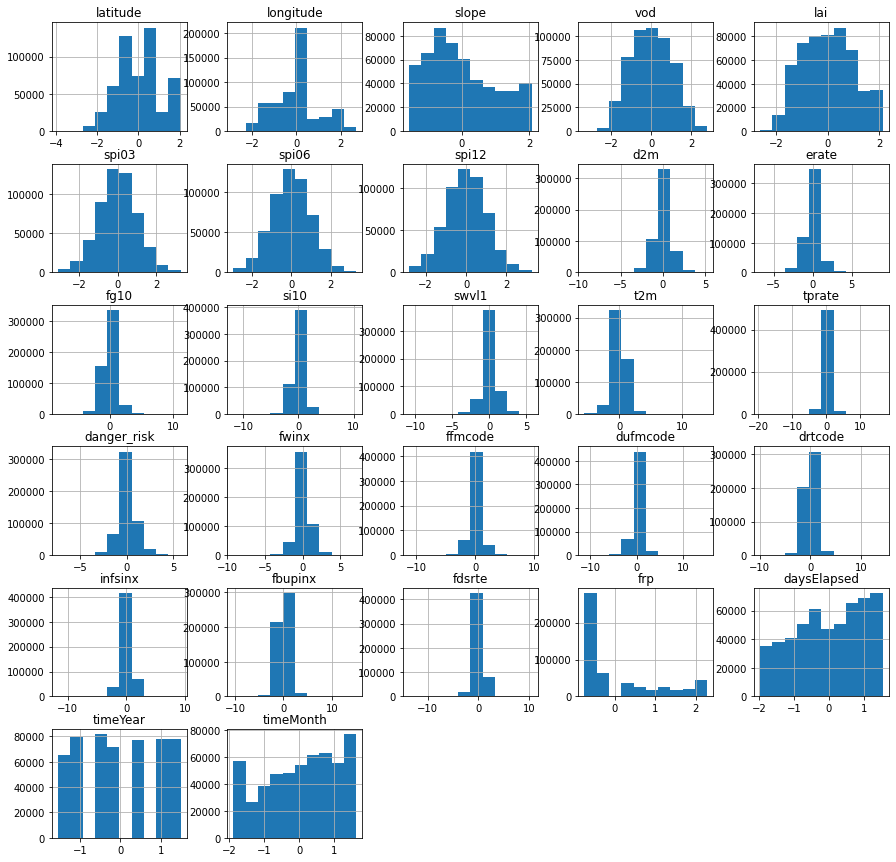

In [16]:
train_yj.drop('fuel_load', axis = 1).hist(figsize = (15,15))

In [14]:
# Convert data to H2O frame
train_data = h2o.H2OFrame(train_yj)
test_data = h2o.H2OFrame(test_yj)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [15]:
# Define Regressor model
aml = H2OAutoML(max_runtime_secs = 6*60*60, seed = 1, stopping_metric = "mse",# stopping_tolerance = 0.01,
                preprocessing = ["target_encoding"]) # TE is not necessary, I leave it here for future use
    
# Fit
aml.train(y = y, training_frame = train_data)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [22]:
# View the AutoML Leaderboard - uses validation metrics
lb = aml.leaderboard
lb.head()
#lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20210526_163358,1.27523,1.12926,1.27523,0.882294,nan
StackedEnsemble_BestOfFamily_AutoML_20210526_163358,1.30256,1.1413,1.30256,0.892616,nan
GBM_grid__1_AutoML_20210526_163358_model_56,1.32805,1.15241,1.32805,0.903818,nan
GBM_grid__1_AutoML_20210526_163358_model_44,1.36645,1.16895,1.36645,0.917675,nan
GBM_grid__1_AutoML_20210526_163358_model_25,1.3684,1.16979,1.3684,0.91936,nan
GBM_grid__1_AutoML_20210526_163358_model_16,1.37217,1.1714,1.37217,0.92082,nan
GBM_grid__1_AutoML_20210526_163358_model_34,1.37877,1.17421,1.37877,0.921186,nan
GBM_grid__1_AutoML_20210526_163358_model_61,1.3898,1.1789,1.3898,0.927744,nan
XGBoost_grid__1_AutoML_20210526_163358_model_29,1.39047,1.17918,1.39047,0.921038,nan
XGBoost_grid__1_AutoML_20210526_163358_model_16,1.39362,1.18051,1.39362,0.922007,nan


In [19]:
# Performance on test data
aml.leader.model_performance(test_data)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 1.236105102237219
RMSE: 1.111802636369072
MAE: 0.8685875167274616
RMSLE: NaN
R^2: 0.7174143992213066
Mean Residual Deviance: 1.236105102237219
Null degrees of freedom: 132508
Residual degrees of freedom: 132490
Null deviance: 579630.3950803856
Residual deviance: 163795.05099235164
AIC: 404171.5740023891


In [17]:
# Predict using test data
pre = np.exp(aml.predict(test_data).as_data_frame())

# Get performance - transformed
obs = np.exp(test_data[y].as_data_frame())
mean_absolute_error(obs, pre)

stackedensemble prediction progress: |████████████████████████████████████| 100%


43.970377650295454

In [ ]:
# Plot predictions
plt.plot(obs[0:100])
plt.plot(pre[0:100])
plt.title('Model predictions')
plt.ylabel('Dry Matter')
plt.xlabel('')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

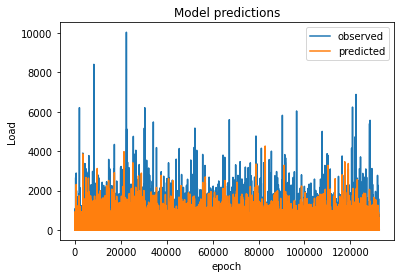

In [21]:
# Plot predictions
plt.plot(obs)
plt.plot(pre)
plt.title('Model predictions')
plt.ylabel('Dry Matter')
plt.xlabel('')
plt.legend(['observed', 'predicted'], loc='upper right')
plt.show()

In [23]:
# The leader model is stored here
# aml.leader

# Save the leader model
leadermodel_path = h2o.save_model(aml.leader, path = "/home/moc0/ai-vegetation-fuel/data/outputs", force = True)
print(leadermodel_path)

/home/moc0/ai-vegetation-fuel/data/outputs/StackedEnsemble_AllModels_AutoML_20210526_163358


In [ ]:
# Get second model
m2 = h2o.get_model(lb[1,"model_id"])

# Predict using test data
pre = np.exp(m2.predict(test_data).as_data_frame())

# Get performance - transformed
mean_absolute_error(obs, pre)

In [ ]:
# Get the third model
m3 = h2o.get_model(lb[2,"model_id"])

# Predict using test data
pre = np.exp(m3.predict(test_data).as_data_frame())

# Get performance - transformed
mean_absolute_error(obs, pre)

In [ ]:
# Save the third model
model3_path = h2o.save_model(m3, path = "/home/moc0/ai-vegetation-fuel/data/outputs", force = True)
print(model3_path)

In [ ]:
# Load the model
# saved_model = h2o.load_model(model_path)

# Download the model built above to your local machine
# my_local_model = h2o.download_model(model, path="/Users/UserName/Desktop")

# Upload the model that you just downloded above to the H2O cluster
# uploaded_model = h2o.upload_model(my_local_model)

# Variable importance

See https://stackoverflow.com/questions/51640086/is-it-possible-to-get-a-feature-importance-plot-from-a-h2o-automl-model

In [ ]:
m3.varimp(use_pandas=True)

In [ ]:
m3.varimp_plot()

The following functions take a list of models (including an AutoML object or leaderboard slice) as input:

In [ ]:
# These are methods for an AutoML object
# Use h2o.method_name(model_list, test) for a list of models
aml.varimp_heatmap()
#.model_correlation_heatmap()
#.pd_multi_plot()

These functions take a single H2O model as input:

In [ ]:
# Methods for an H2O model
.residual_analysis_plot()
.varimp_plot()
.shap_explain_row_plot()
.shap_summary_plot()
.pd_plot()
.ice_plot()

# Explainability

See https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#explainability and https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_residual_deviance,rmse,mse,mae,rmsle,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210526_163358,1.27523,1.12926,1.27523,0.882294,nan,3532,0.040073,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210526_163358,1.30256,1.1413,1.30256,0.892616,nan,832,0.006005,StackedEnsemble
GBM_grid__1_AutoML_20210526_163358_model_56,1.32805,1.15241,1.32805,0.903818,nan,25290,0.004301,GBM
GBM_grid__1_AutoML_20210526_163358_model_44,1.36645,1.16895,1.36645,0.917675,nan,20651,0.005086,GBM
GBM_grid__1_AutoML_20210526_163358_model_25,1.3684,1.16979,1.3684,0.91936,nan,22563,0.003189,GBM
GBM_grid__1_AutoML_20210526_163358_model_16,1.37217,1.1714,1.37217,0.92082,nan,17613,0.003466,GBM
GBM_grid__1_AutoML_20210526_163358_model_34,1.37877,1.17421,1.37877,0.921186,nan,22080,0.003427,GBM
GBM_grid__1_AutoML_20210526_163358_model_61,1.3898,1.1789,1.3898,0.927744,nan,11391,0.004371,GBM
XGBoost_grid__1_AutoML_20210526_163358_model_29,1.39047,1.17918,1.39047,0.921038,nan,94728,0.001946,XGBoost
XGBoost_grid__1_AutoML_20210526_163358_model_16,1.39362,1.18051,1.39362,0.922007,nan,150114,0.004169,XGBoost


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

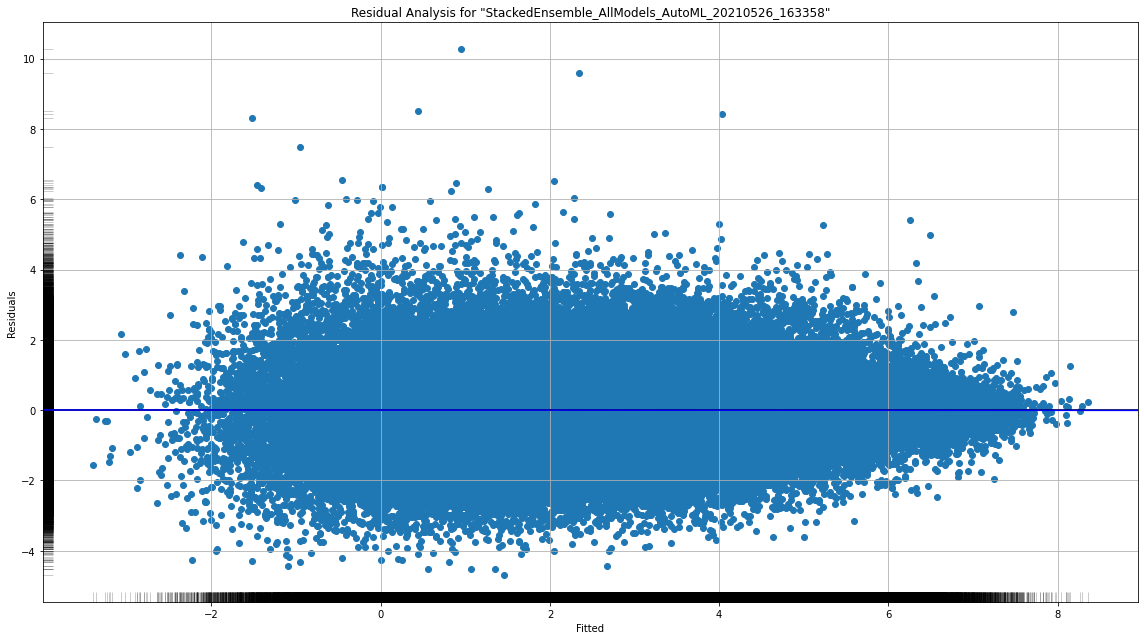

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

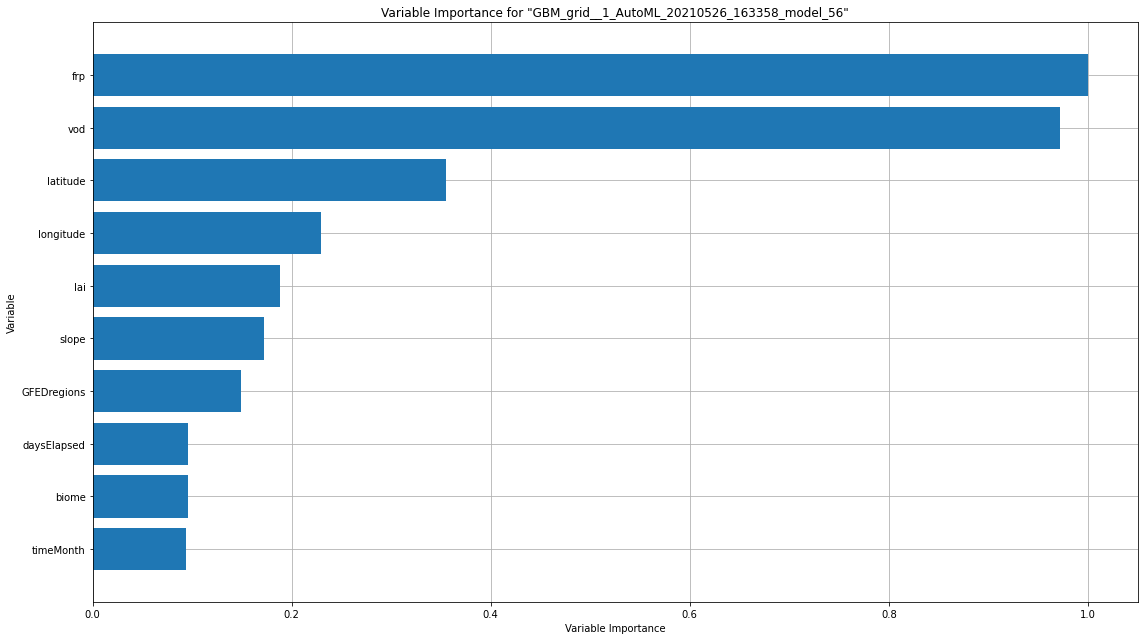

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

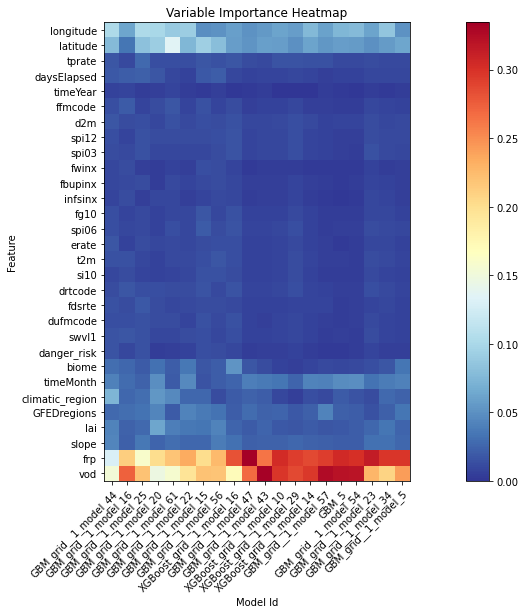

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

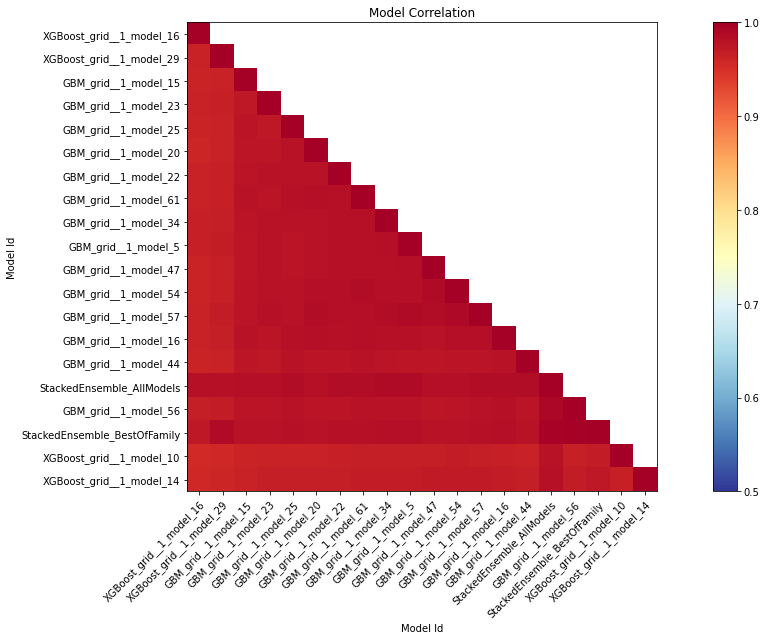

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

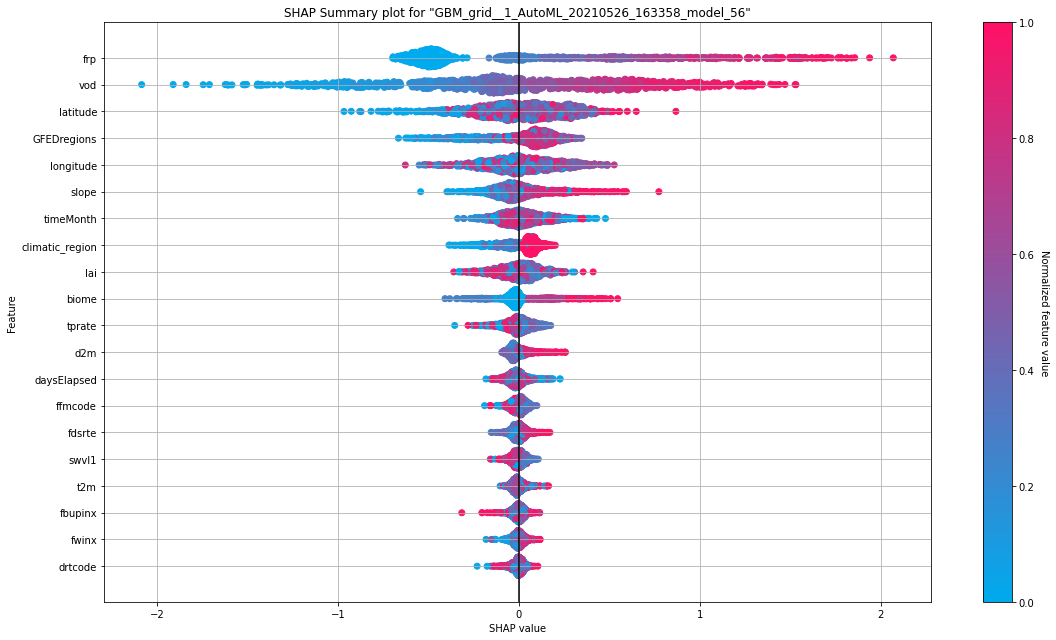

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

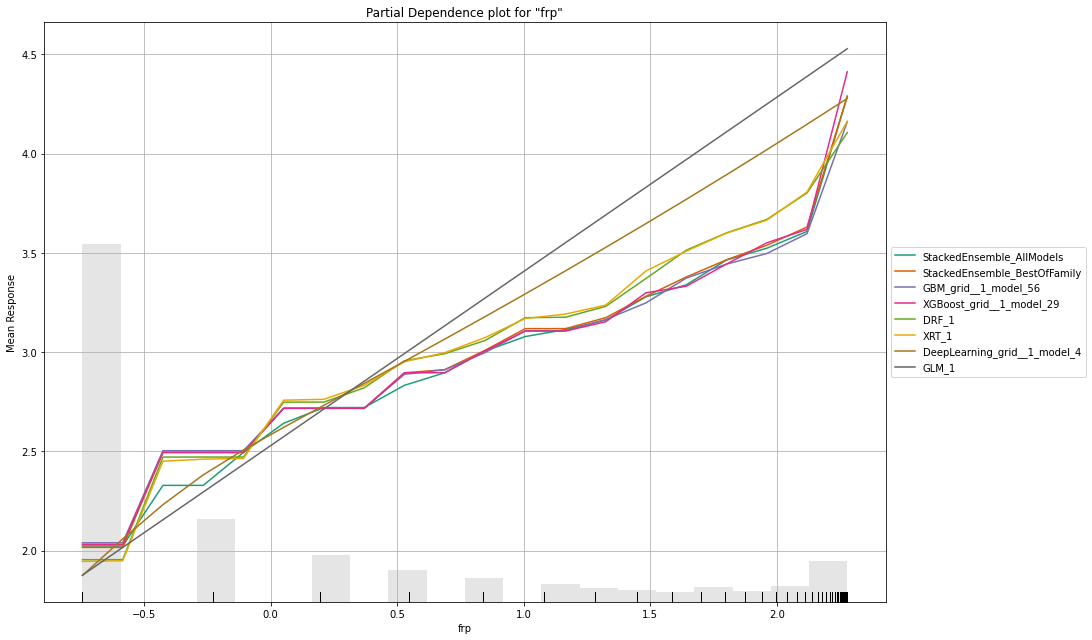

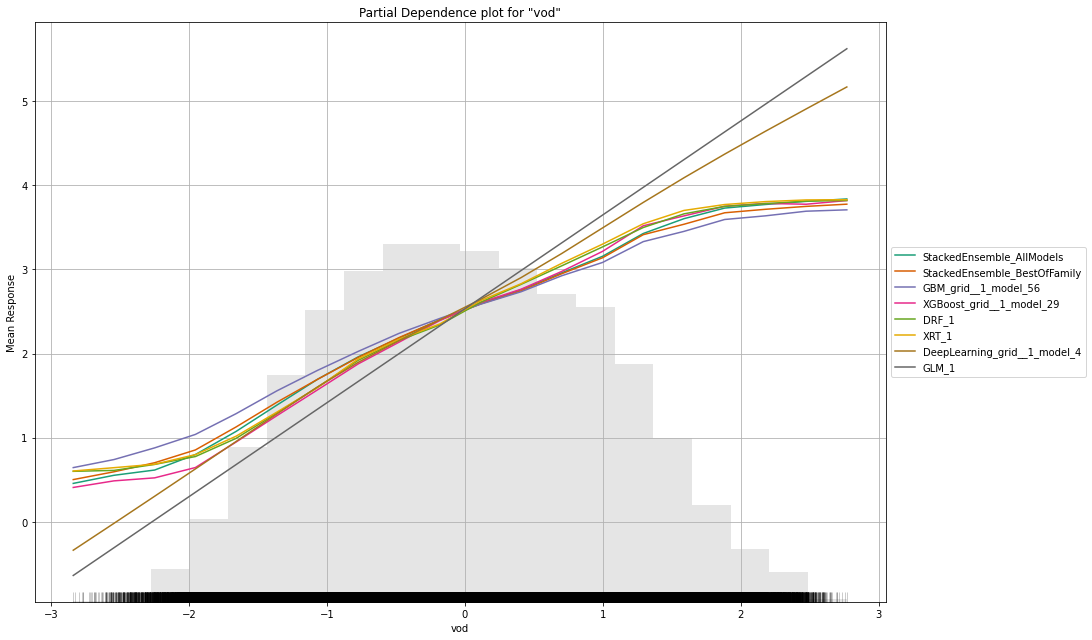

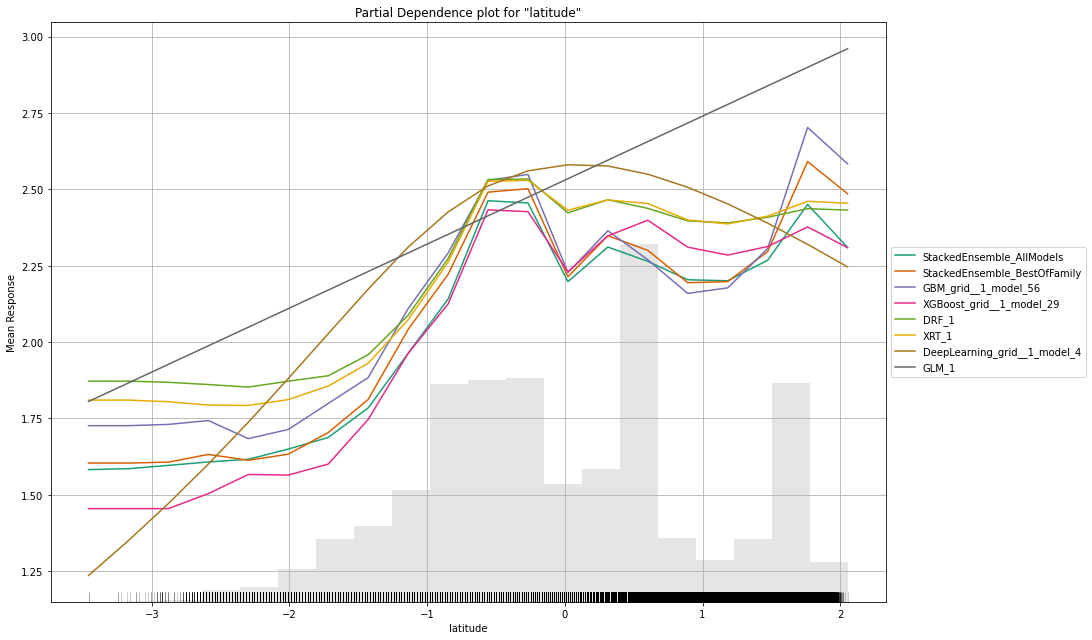

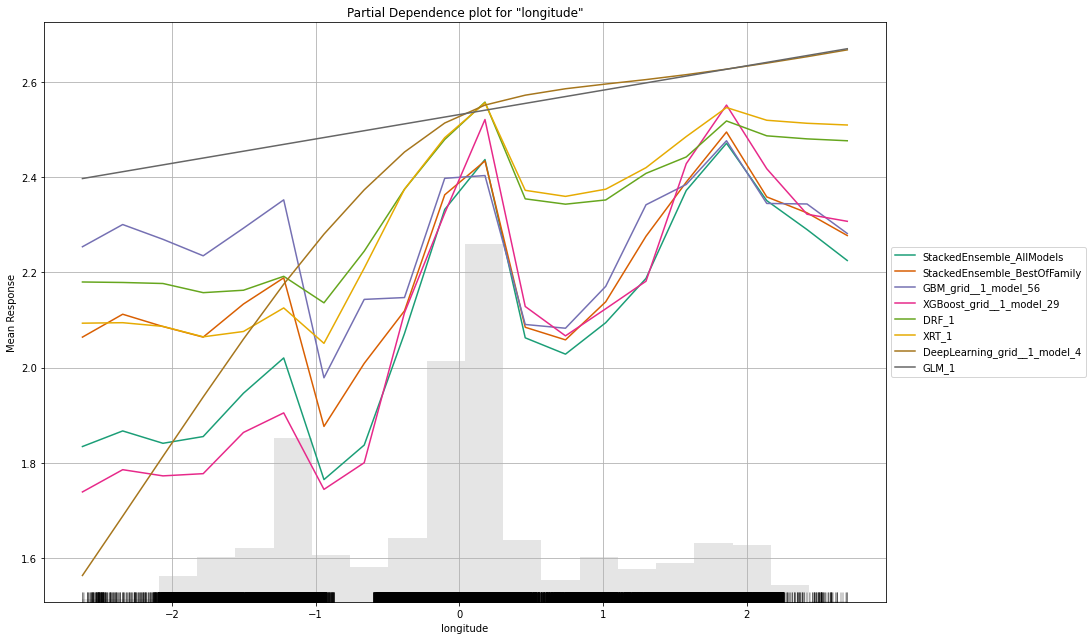

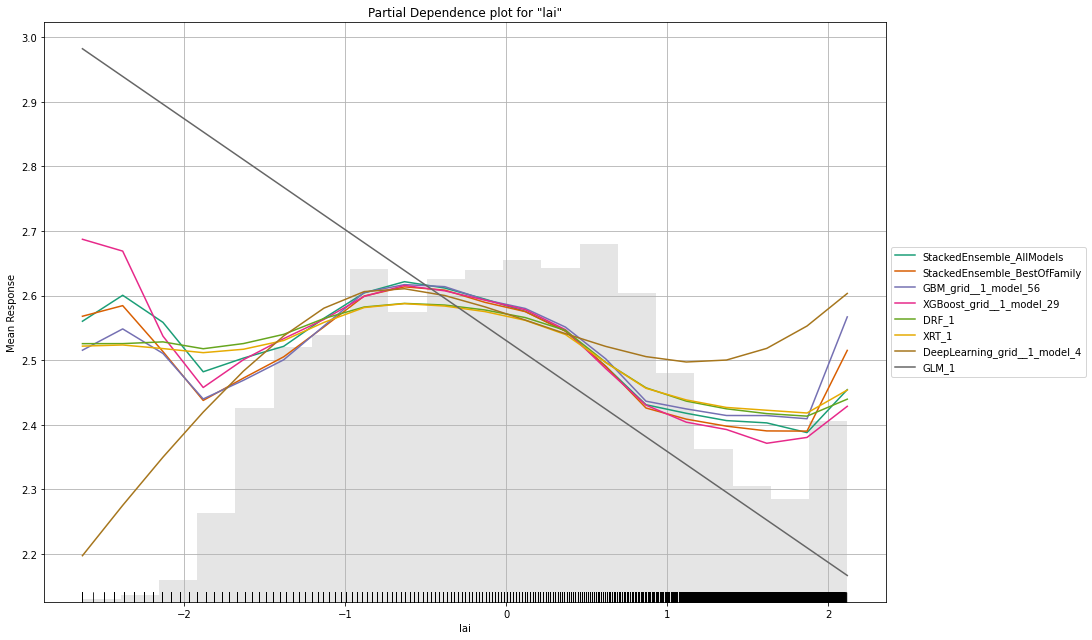

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

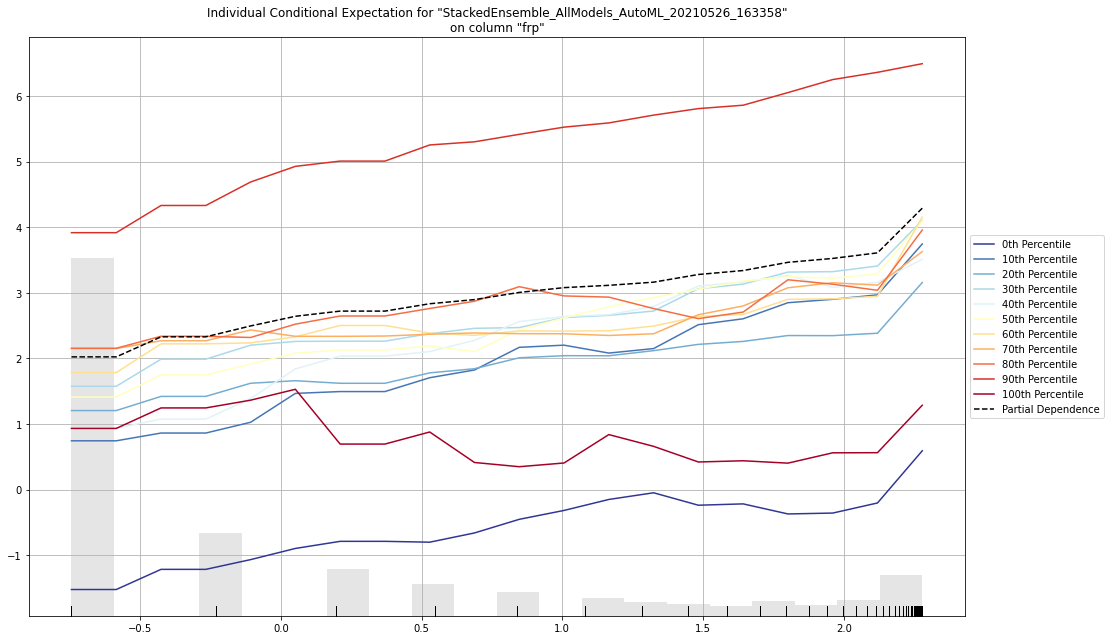

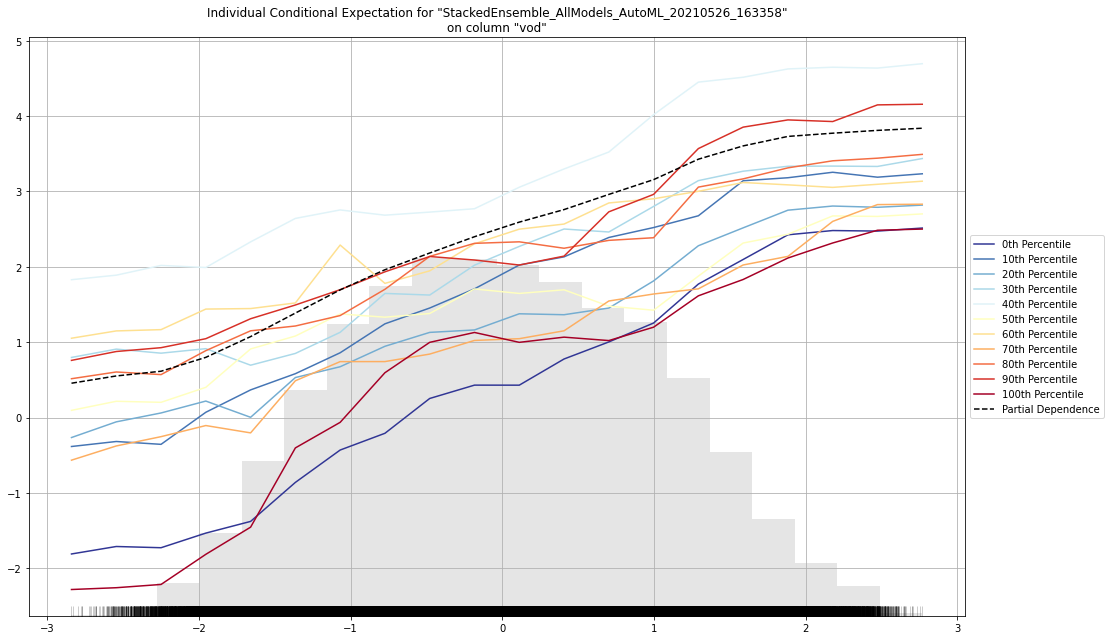

H2OJobCancelled: Job<$03017f00000136d4ffffffff$_8d6e06a5fd10a858e0c47c366aad4681> was cancelled by the user.

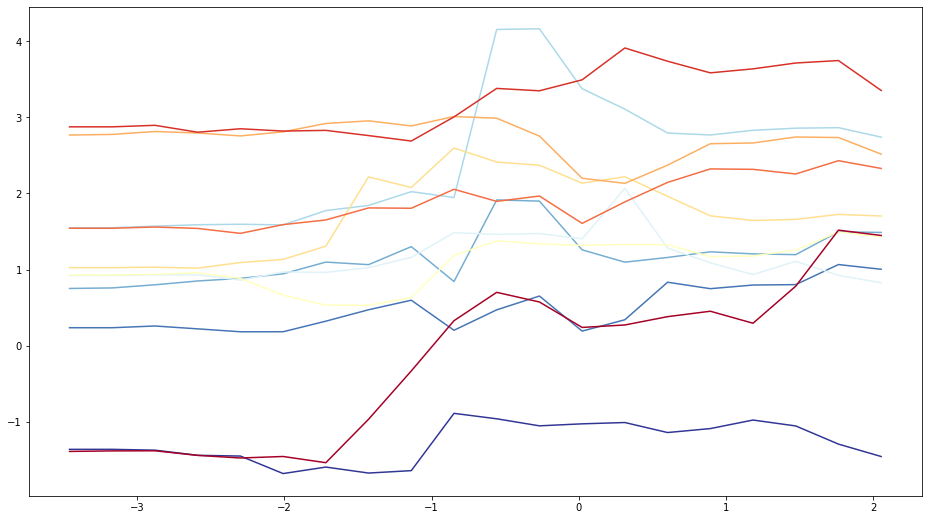

In [24]:
# Explain an AutoML object
exa = aml.explain(test_data)

# Resources

H2O AutoML:
- https://towardsdatascience.com/a-deep-dive-into-h2os-automl-4b1fe51d3f3e#:~:text=H2O%20AutoML%20functionalities&text=Necessary%20data%20pre%2Dprocessing%20capabilities,are%20tuned%20using%20cross%2Dvalidation.

Data transformations:
- https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
- https://www.kaggle.com/product-feedback/164183
- https://medium.com/@patricklcavins/using-scipys-powertransformer-3e2b792fd712
- https://machinelearningmastery.com/power-transforms-with-scikit-learn/
- https://robjhyndman.com/hyndsight/transformations/
- https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros